<a href="https://colab.research.google.com/github/otavioml/Chess-Data-Analysis/blob/main/Chess_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de partidas de xadrez do Lichess



##Imports e leitura da base de dados

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as ss

In [29]:
plt.rcParams['figure.figsize']  = (16, 14)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/otavioml/Chess-Data-Analysis/main/Chess100k.csv')

## Limpeza dos dados e adição de novas colunas

In [31]:
#Limpeza dos dados
#Padronização do tipo da coluna Numer_of_Moves
df['Number_of_Moves'] =  pd.to_numeric(df['Number_of_Moves'], errors='coerce')

#Remoção das partidas com menos de 3 movimentos que foram abandonadas ou terminadas por tempo
condition = (df['Number_of_Moves'] >= 3) | (df['Termination'] == 'Normal')
df = df.loc[condition]

#limpeza das linhas nulas
df = df.dropna()

In [32]:
#Adição das colunas média e razão
#RatioElo = Maior elo da partida dividido pelo menor elo da partida, quanto mais próximo de 1 mais igual foi a disputa
df['RatioElo'] = df.apply(lambda x: x['BlackElo']/x['WhiteElo'] if x['BlackElo']>x['WhiteElo'] else x['WhiteElo']/x['BlackElo'], axis = 1)
df['MatchElo'] = (df['BlackElo']+df['WhiteElo'])/2

#Colunas de interesse
df = df[['WhiteElo','BlackElo','RatioElo','MatchElo','Winner','InitialTime','Increment','TimeControl','Opening','ECO','Number_of_Moves','Site']]
df.shape

(99569, 12)

##Dataframe Final e dados sobre as colunas

In [33]:
df.head()

WhiteElo  BlackElo  ...  Number_of_Moves                          Site
0      1639      1403  ...               13  https://lichess.org/j1dkb5dw
1      1654      1919  ...               18  https://lichess.org/a9tcp02g
2      1643      1747  ...               11  https://lichess.org/szom2tog
3      1824      1973  ...               47  https://lichess.org/rklpc7mk
4      1765      1815  ...               23  https://lichess.org/1xb3os63

[5 rows x 12 columns]

In [34]:
#Short description of the dataframe
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

WhiteElo  BlackElo  RatioElo  ... InitialTime Increment Number_of_Moves
count  99569.00  99569.00  99569.00  ...    99569.00  99569.00        99569.00
mean    1606.69   1596.46      1.11  ...      300.89      2.91           34.01
std      202.38    207.59      0.10  ...      288.00      4.39           16.23
min      782.00    789.00      1.00  ...        0.00      0.00            1.00
25%     1476.00   1464.00      1.04  ...      120.00      0.00           23.00
50%     1602.00   1589.00      1.08  ...      240.00      1.00           32.00
75%     1740.00   1733.00      1.15  ...      360.00      5.00           43.00
max     2403.00   2386.00      2.34  ...     1800.00     30.00          153.00

[8 rows x 7 columns]

##Primeiras Visualizações

In [35]:
#df.hist(bins=20, column=['WhiteElo', 'BlackElo', 'RatioElo', 'MatchElo', 'Number_of_Moves'],edgecolor='black',)
titles = ('MatchElo', 'Number_of_Moves')
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles= titles
)

fig.add_trace(
    go.Histogram(x=df['MatchElo'], nbinsx=50),
    row = 1, col = 1
)
fig.update_xaxes(title_text='Rank Médio da Partida', row=1, col=1)

fig.add_trace(
    go.Histogram(x=df['Number_of_Moves'],nbinsx=50),
    row = 1, col = 2
)
fig.update_xaxes(title_text='Número de Movimentos da Partida', row=1, col=2)

fig.update_layout(showlegend=False,
                  height=400, width=900,
                  title_text='Visão Geral (Histogramas)')

In [36]:
titles = ('RatioElo', 'InitialTime')
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles= titles
)
fig.add_trace(
    go.Box(y=df['RatioElo'], boxpoints=False),
    row = 1, col = 1
)
fig.update_yaxes(title_text='Elo', row=1, col=1)

fig.add_trace(
    go.Box(y=df['InitialTime'], boxpoints=False),
    row = 1, col = 2
)
fig.update_yaxes(title_text='Tempo(s)', row=1, col=2)

fig.update_layout(showlegend=False,
                  height=450, width=900,
                  title_text='Visão Geral (Boxplots)')


##Análises Iniciais


In [37]:
df_winner = df[df['Winner'] != 'Draw'].groupby('Winner').count()['ECO'] #Número de vitórias de cada cor
fig = px.bar(df_winner, x=df_winner.index, y='ECO')
fig.update_layout(height=450, width=500, title_text='Vitórias por cor')
fig.update_yaxes(title_text='Vitórias')
fig.update_xaxes(title_text='Cor')
fig.show()

Utilizando a média do número de movimentos como dado amostral, podemos provar que o mesmo dado amostral tende a igualar com o dado real a medida que o tamanho da amostra aumente.

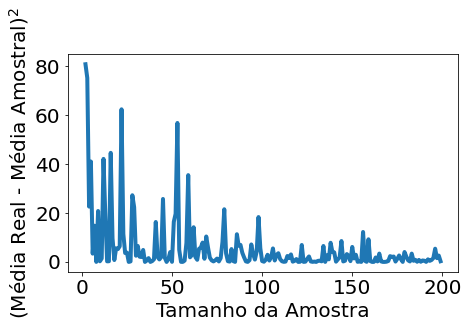

In [38]:


real_mean = df['Number_of_Moves'].mean()

sizes = np.arange(2, 200)
diff = []
for size in sizes:
  df_sample = df.sample(size, replace=True)
  diff.append((real_mean - df_sample['Number_of_Moves'].mean()) ** 2)

plt.figure(figsize=(7,4))
plt.plot(sizes, diff)
plt.ylabel('(Média Real - Média Amostral)$^2$')
plt.xlabel('Tamanho da Amostra')
plt.show()

#Como mostrado no gráfico abaixo, temos garantia que 100000 dados representa 
#a população com assiduidade, resultando em um erro muito próximo ou se não
#igual a 0

Como mostrado no gráfico acima, temos garantia que 100000 dados representa a população com assiduidade, resultando em um erro muito próximo ou se não igual a 0.

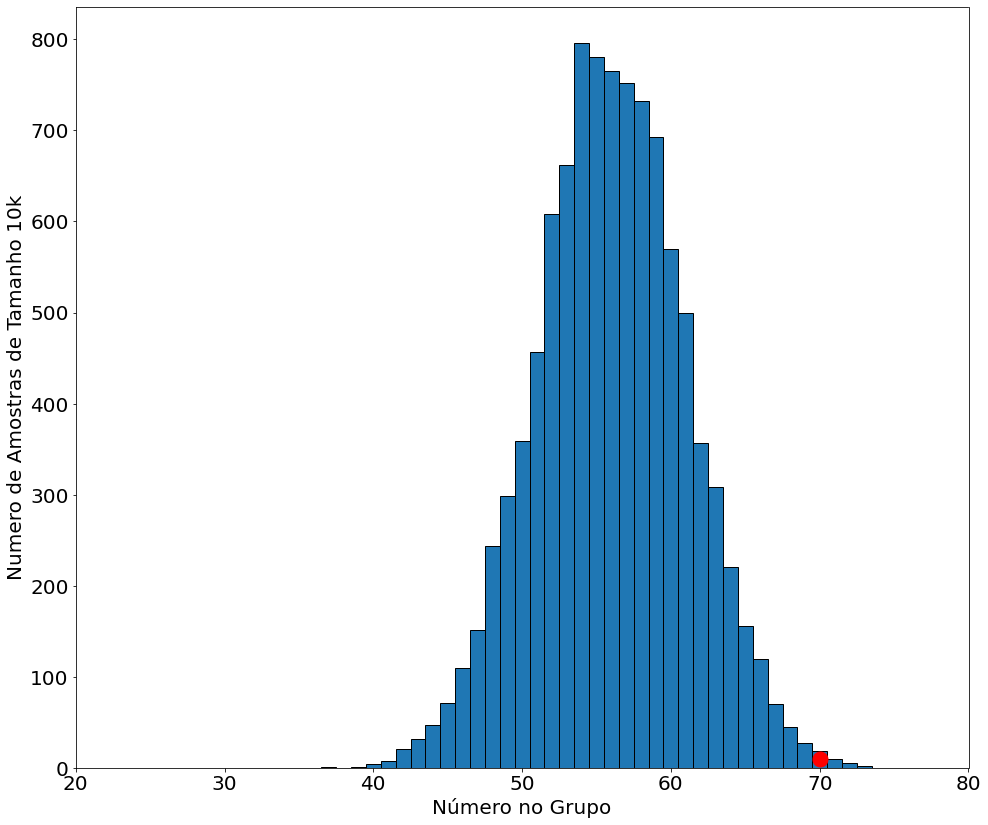

In [39]:
def sample_proportion(pop_size, proportion, n=10000):
  group = pop_size * proportion
  results = np.zeros(n)
  for i in range(n):
    sample = np.random.randint(0, pop_size, 100)
    results[i] = np.sum(sample < group)

  return results

proportions = sample_proportion(pop_size=100000, proportion=0.56)
bins = np.linspace(1, 100, 100) + 0.5
plt.hist(proportions, bins=bins, edgecolor='k')
plt.xlim(20, 80)
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Número no Grupo')
plt.plot([70], [10], 'ro', ms=15)
plt.show()

In [40]:
np.percentile(proportions, 95)

64.0

Com 5% de chances podemos ter 64% de vitória das brancas. 70% de vitórias das brancas já é um resultado bem raro baseado na distribuição anterior.

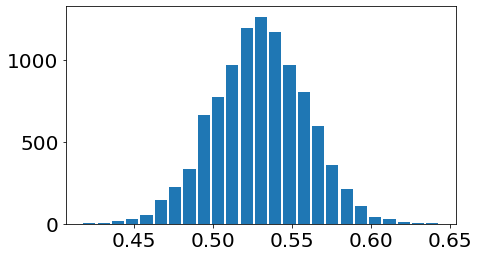

In [41]:
est_test = df_winner[1] / df_winner.sum() #Porcentagem de vitórias das brancas observada

#Bootstrap da porcentagem de vitória das brancas
size = 300
n = 10000
partidas = np.zeros(n)
for i in range(n):
  sample = df.sample(size, replace=True)
  df_aux = sample[sample['Winner'] != 'Draw'].groupby('Winner').count()['ECO']
  partidas[i] = df_aux[1]/df_aux.sum()
plt.figure(figsize=(7,4))
plt.hist(partidas, bins=25, rwidth=0.85)
plt.show()


In [42]:
alpha = 0.95
X = partidas
LI = X.mean() - ss.norm.ppf(alpha+(1-alpha)/2).round(2) * (X.std(ddof=1) / np.sqrt(n))
LS = X.mean() + ss.norm.ppf(alpha+(1-alpha)/2).round(2) * (X.std(ddof=1) / np.sqrt(n))
print(f'LI = {LI} \nLS = {LS}')
print(est_test)

LI = 0.5292095204017053 
LS = 0.5303544470367778
0.5298088907353552


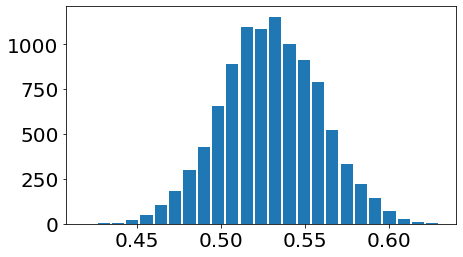

In [43]:
import random

aberturas = list(df['ECO'].unique())
df_randomizado = df.copy()
df_randomizado['RANDOM_ECO'] = pd.Series(random.choices(aberturas, k = len(df_randomizado)))
df_randomizado.head()

size = 300
n = 10000
partidas = np.zeros(n)
for i in range(n):
  sample = df_randomizado.sample(size, replace=True)
  df_aux = sample[sample['Winner'] != 'Draw'].groupby('Winner').count()['RANDOM_ECO']
  partidas[i] = df_aux[1]/df_aux.sum()
plt.figure(figsize=(7,4))
plt.hist(partidas, bins=25, rwidth=0.85)
plt.show()

In [44]:
alpha = 0.95
X = partidas
LI = X.mean() - ss.norm.ppf(alpha+(1-alpha)/2).round(2) * (X.std(ddof=1) / np.sqrt(n))
LS = X.mean() + ss.norm.ppf(alpha+(1-alpha)/2).round(2) * (X.std(ddof=1) / np.sqrt(n))
print(f'LI = {LI} \nLS = {LS}')
print(est_test)

LI = 0.5292028752439503 
LS = 0.5303494366938569
0.5298088907353552


In [45]:
"""A função lista em um dataframe, as 10 aberturas mais utilizadas
e a porcentagem de vitórias de cada cor com ela
data = dataframe analisado
n = número mínimo de partidas jogadas com cada abertura
all_lines = True retorna o dataframe completo, False retorna apnas as 10 aberturas mais usadas
reset_index = True reconstrói o index do dataframe 

retorno = 10 aberturas mais usadas """

aberturas = list(df['ECO'].unique())

def top10_oppenings(data, n=1000, all_lines=False, reset_index=False, orderby = 'Games'):
  linhas = list()
  for abertura in aberturas:
    df_ab = data[data['ECO'] == abertura][['ECO', 'Winner']]
    ww = (df_ab[df_ab['Winner'] == 'White']['Winner'].count())
    bw = (df_ab[df_ab['Winner'] == 'Black']['Winner'].count())
    total = bw + ww
    linhas.append([abertura, total, ww, bw])
  df_aberturas = pd.DataFrame(data=linhas, columns=['ECO','Total','WhiteWins','BlackWins'])
  df_aberturas = df_aberturas[df_aberturas['Total']>n]
  df_aberturas['WhiteWins_percent'] = ((df_aberturas['WhiteWins']/(df_aberturas['WhiteWins']+df_aberturas['BlackWins']))*100).round(2)
  df_aberturas['BlackWins_percent'] = 100 - df_aberturas['WhiteWins_percent']

  if orderby == 'Games':
    df_aberturas = df_aberturas.sort_values(by=['Total'], ascending=False)
  else:
      df_aberturas = df_aberturas.sort_values(by=[orderby+'Wins_percent'], ascending=False)

  if reset_index:
    df_aberturas.reset_index(inplace=True)

  if all_lines:
    return df_aberturas
  return df_aberturas[:10]

def aberturas_intervalo(data):
  return data[(data['WhiteWins_percent'] > (LS*100)) | (data['WhiteWins_percent'] < (LI*100))]


In [66]:
top_black_oppening = top10_oppenings(df, orderby='Black')
top_white_oppening = top10_oppenings(df, orderby='White')
top_oppening = top10_oppenings(df,reset_index=True)

In [67]:
top_oppening

index  ECO  Total  ...  BlackWins  WhiteWins_percent  BlackWins_percent
0     27  A00   7595  ...       4025              47.00              53.00
1      4  B00   4866  ...       2258              53.60              46.40
2      0  C00   4860  ...       2384              50.95              49.05
3      8  A40   4786  ...       1987              58.48              41.52
4     56  D00   4170  ...       1926              53.81              46.19
5     15  B01   4048  ...       1756              56.62              43.38
6     38  C41   3689  ...       1516              58.90              41.10
7      6  C20   3649  ...       1924              47.27              52.73
8     55  B20   2690  ...       1546              42.53              57.47
9     32  D02   2005  ...        870              56.61              43.39

[10 rows x 7 columns]

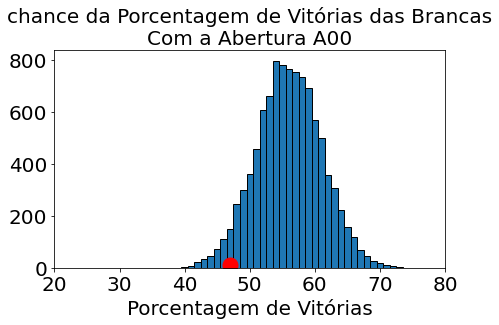

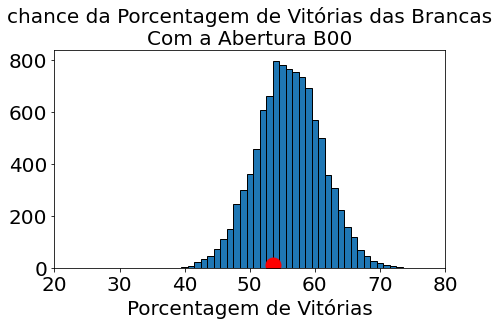

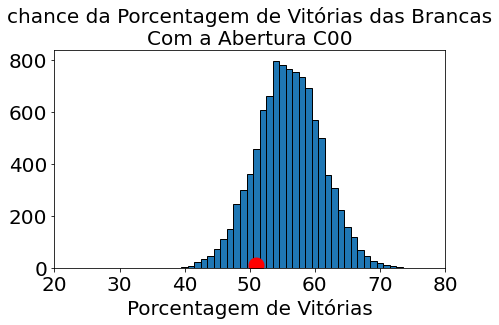

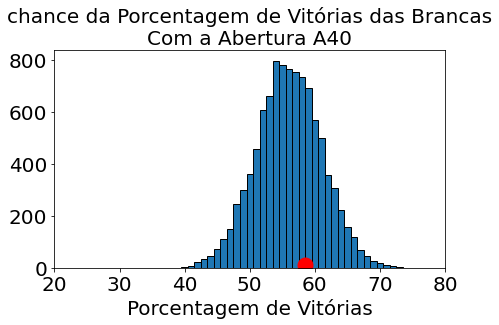

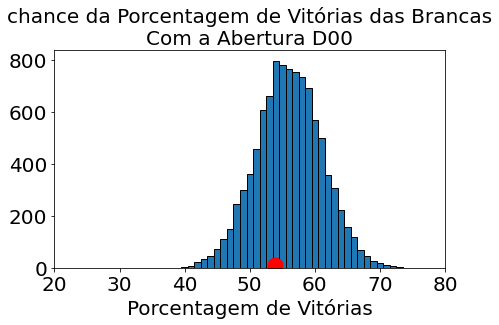

In [69]:
def icplot(values, test, oppen, wins):
  plt.figure(figsize=(7,5))
  wins = 'Brancas' if wins == 'White' else 'Pretas'
  bins = np.linspace(1, 100, 100) + 0.5
  plt.hist(proportions, bins=bins, edgecolor='k')
  plt.xlim(20, 80)
  plt.title(f'Chance da Porcentagem de Vitórias das {wins}\nCom a Abertura {oppen}')
  plt.xlabel('Porcentagem de Vitórias')
  plt.plot([test], [10], 'ro', ms=10)
  plt.show()

def build_filtro(oppenings):
  category = list(np.zeros(len(df)))
  for i, oppen in enumerate(oppenings):
    aux = (1*(df['ECO'] == oppen)).replace(1,i+1)
    category += aux
  return list(category)

def ic_oppenings(df_oppenings, n_op=5, wins='White'):
  oppenings = df_oppenings[:n_op]['ECO']
  observado = df_oppenings[:n_op][f'{wins}Wins_percent']
  df_copy = df.copy()
  filtro = build_filtro(oppenings)
  n = 5000
  result = np.zeros((n_op,n))
  
  for i in range(n):
    np.random.seed(i)
    np.random.shuffle(filtro)
    df_copy['Filtro'] = filtro
    for j in range(1,n_op+1):
      random_oppen = df_copy[df_copy['Filtro']==j]
      m0 = (random_oppen['Winner']==wins).sum()
      result[j-1,i] = (m0*100)/len(random_oppen)
  
  for i in range(n_op):
    icplot(result[i],observado[i],oppenings[i],wins)

ic_oppenings(top_oppening)

In [20]:
#Teste de Permutação
filtro = df['ECO'] == top_white_oppening.iloc[0,0]
n = 5000
result = np.zeros(n)
for i in range(n):
  np.random.seed(i)
  np.random.shuffle(filtro.values)
  random_open = df[filtro]
  m0 = (random_open['Winner']=='White').sum()
  result[i] = m0/len(df[filtro])
li = np.percentile(result,2.5)
ls = np.percentile(result, 97.5)

In [21]:
#Average moves per
df_averageMovesPerGame = df['Number_of_Moves'].mean()
df_averageMovesPerGame

34.00786389338047

In [22]:
df_bullet = df[df['InitialTime']<=60]
df_bullet_oppening = top10_oppenings(df_bullet,50)
df_bullet_oppening

ECO  Total  WhiteWins  BlackWins  WhiteWins_percent  BlackWins_percent
27  A00   3964       2048       1916              51.66              48.34
4   B00   1743        947        796              54.33              45.67
8   A40   1505        899        606              59.73              40.27
0   C00   1419        712        707              50.18              49.82
15  B01    892        446        446              50.00              50.00
9   B06    831        436        395              52.47              47.53
22  B07    644        305        339              47.36              52.64
13  A01    490        275        215              56.12              43.88
56  D00    464        255        209              54.96              45.04
41  A04    464        245        219              52.80              47.20

In [23]:
bullet_win = df_bullet.groupby('Winner').count()['ECO']
print(bullet_win['White']/bullet_win.sum())

0.517212391240385


In [24]:
def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

0.19747253341191665


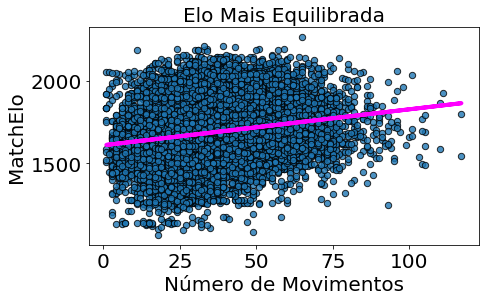

0.10895042367835796


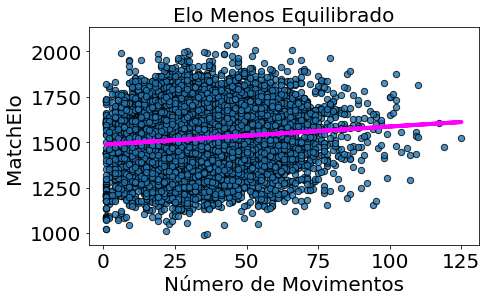

In [25]:
tipoPartida = 'Bullet'
sample = 10000

temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)
eloMean = temp['RatioElo'].mean()
temp = temp[temp['RatioElo'] < eloMean]


x = temp['Number_of_Moves']
y = temp['MatchElo']
print(x.corr(y, method= 'pearson'))
#print(x.corr(y, method= 'spearman'))


alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.figure(figsize=(7,4))
plt.plot(x, y_model, color='magenta')
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
plt.xlabel('Número de Movimentos')
plt.ylabel('MatchElo')
plt.title('Elo Mais Equilibrada')
plt.show()

temp = df.where(df['TimeControl'] == 'Rapid').dropna()#.sample(sample)
eloMean = temp['RatioElo'].mean()
temp = temp[temp['RatioElo'] > eloMean]


x = temp['Number_of_Moves']
y = temp['MatchElo']
print(x.corr(y, method= 'pearson'))
#print(x.corr(y, method= 'spearman'))


alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.figure(figsize=(7,4))
plt.plot(x, y_model, color='magenta')
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
plt.ylabel('MatchElo ')
plt.xlabel('Número de Movimentos')
plt.title('Elo Menos Equilibrado')
plt.show()

In [26]:
 def plotGrafico(ax, dataframe, coluna1, coluna2):
  
  x = dataframe[coluna1]
  y = dataframe[coluna2]

  alpha, beta = least_squares_fit(x, y)
  y_model = beta * x + alpha
  ax.plot(x, y_model, color='magenta')
  ax.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
  ax.set(xlabel=coluna1, ylabel=coluna2)


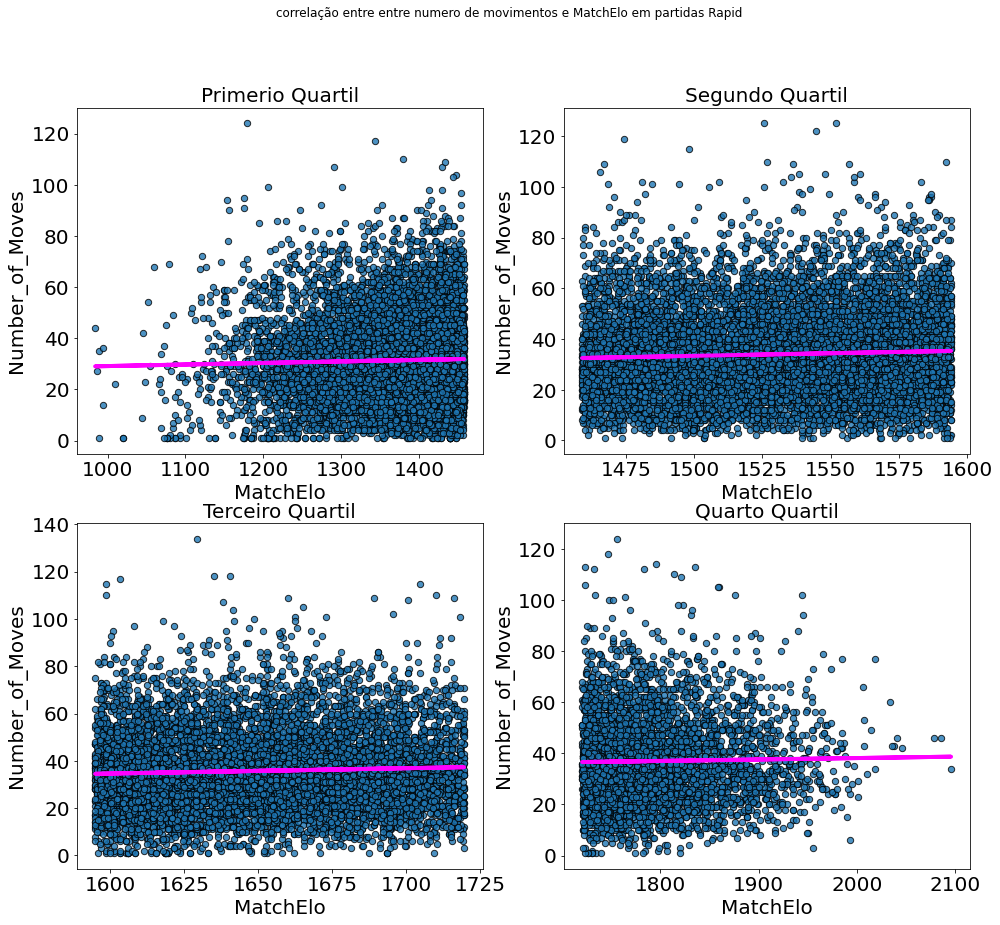

In [35]:
tipoPartida = 'Bullet'
variavel = 'MatchElo'
sample = 10000

temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)



q1 = temp[temp['MatchElo'] < 1458.5]
q2 = temp[(temp['MatchElo'] > 1458.5) & (temp['MatchElo'] < 1594.5)]
q3 = temp[(temp['MatchElo'] > 1594.5) & (temp['MatchElo'] < 1720)]
q4 = temp[temp['MatchElo'] > 1720]

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("correlação entre entre numero de movimentos e " + variavel + " em partidas " + tipoPartida )
axes[0,0].set_title("Primerio Quartil")
plotGrafico(axes[0,0], q1, variavel, 'Number_of_Moves')
axes[0,1].set_title("Segundo Quartil")
plotGrafico(axes[0,1], q2, variavel, 'Number_of_Moves')
axes[1,0].set_title("Terceiro Quartil")
plotGrafico(axes[1,0], q3, variavel, 'Number_of_Moves')
axes[1,1].set_title("Quarto Quartil")
plotGrafico(axes[1,1], q4, variavel, 'Number_of_Moves')



-0.16126428316493338


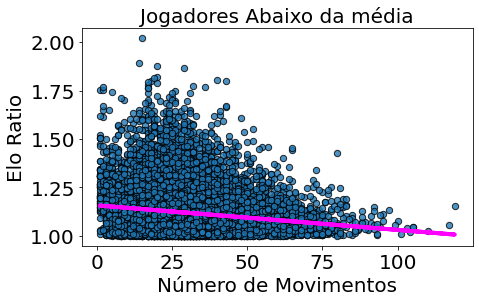

-0.08352651361843375


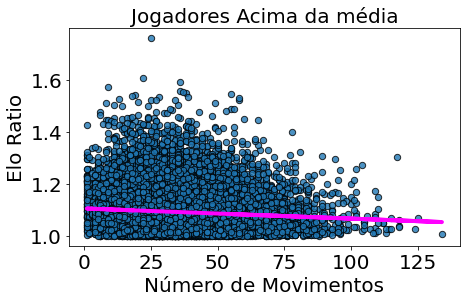

In [31]:
tipoPartida = 'Bullet'
sample = 10000

temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)
eloMean = temp['MatchElo'].mean()
temp = temp[temp['MatchElo'] < eloMean]


x = temp['Number_of_Moves']
y = temp['RatioElo']
print(x.corr(y, method= 'pearson'))
#print(x.corr(y, method= 'spearman'))


alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.figure(figsize=(7,4))
plt.plot(x, y_model, color='magenta')
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
plt.xlabel('Número de Movimentos')
plt.ylabel('Elo Ratio')
plt.title('Jogadores Abaixo da média')
plt.show()

temp = df.where(df['TimeControl'] == 'Rapid').dropna()#.sample(sample)
eloMean = temp['MatchElo'].mean()
temp = temp[temp['MatchElo'] > eloMean]


x = temp['Number_of_Moves']
y = temp['RatioElo']
print(x.corr(y, method= 'pearson'))
#print(x.corr(y, method= 'spearman'))


alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.figure(figsize=(7,4))
plt.plot(x, y_model, color='magenta')
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
plt.ylabel('Elo Ratio')
plt.xlabel('Número de Movimentos')
plt.title('Jogadores Acima da média')
plt.show()

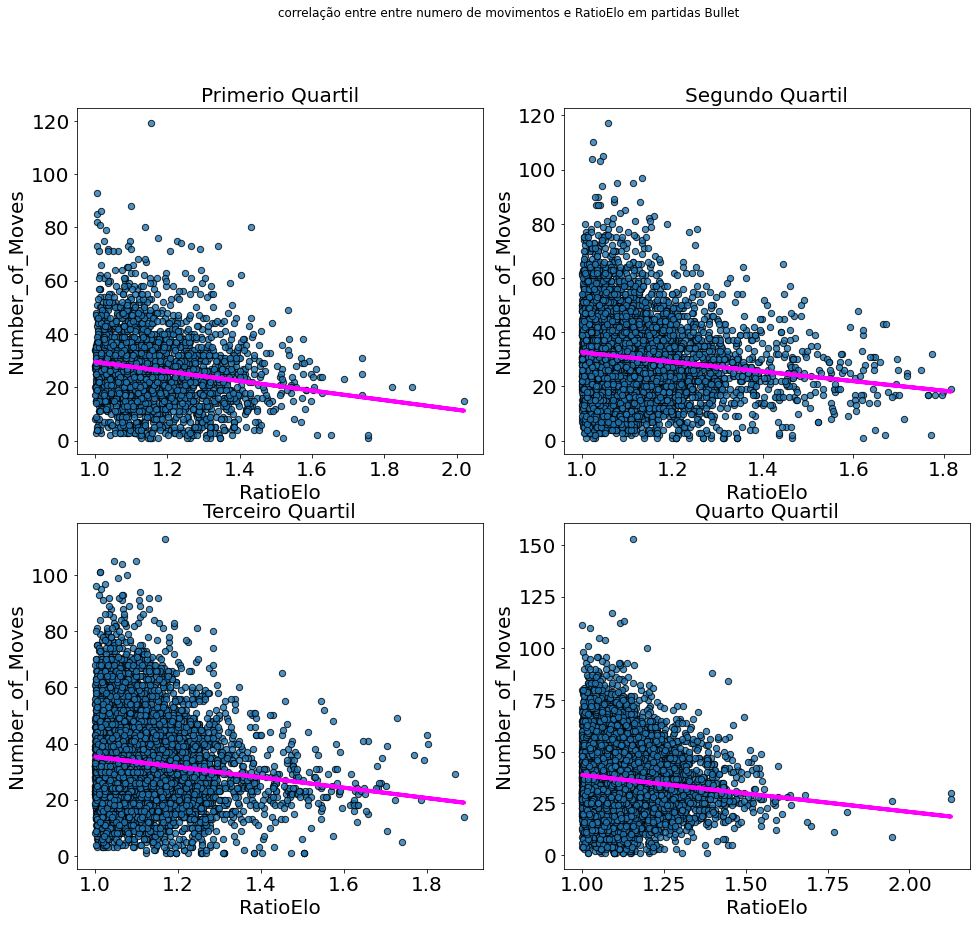

In [34]:
tipoPartida = 'Bullet'
variavel = 'RatioElo'
sample = 10000

temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)



q1 = temp[temp['MatchElo'] < 1458.5]
q2 = temp[(temp['MatchElo'] > 1458.5) & (temp['MatchElo'] < 1594.5)]
q3 = temp[(temp['MatchElo'] > 1594.5) & (temp['MatchElo'] < 1720)]
q4 = temp[temp['MatchElo'] > 1720]

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("correlação entre entre numero de movimentos e " + variavel + " em partidas " + tipoPartida )
axes[0,0].set_title("Primerio Quartil")
plotGrafico(axes[0,0], q1, variavel, 'Number_of_Moves')
axes[0,1].set_title("Segundo Quartil")
plotGrafico(axes[0,1], q2, variavel, 'Number_of_Moves')
axes[1,0].set_title("Terceiro Quartil")
plotGrafico(axes[1,0], q3, variavel, 'Number_of_Moves')
axes[1,1].set_title("Quarto Quartil")
plotGrafico(axes[1,1], q4, variavel, 'Number_of_Moves')
